In [14]:
from os.path import expanduser
home = expanduser('~')
import numpy as np
import pandas as pd
from pymatgen.io.vasp.outputs import Eigenval, Outcar
import matplotlib.pyplot as plt

In [19]:
### Settings
prop_dict = {}
pressures = [0, 5, 10, 15, 20]
symmetries = ['P4nmm', 'Pba2', 'P2c']

loc0 = home + '/Projects/BaCoS2_follow-up/estruc'
loc1 = home + '/Projects/BaCoS2_follow-up/press-estruc'

LABEL_FONT = 14

### Functions
def read_output(prefix, loc0, loc1):

    ### Reading data
    for sym in symmetries:

        band_gaps = []
        mag_moms = []
        energies = []
        volumes = []

        for p in pressures:

                if p == 0:
                    loc = loc0
                    suffix = f'{prefix}_{sym}'
                else:
                    loc = loc1
                    suffix = f'{prefix}_{sym}_p{p}'

                ### Parsing output files
                out = Outcar(f'{loc}/OUTCAR-{suffix}')
                eig = Eigenval(f'{loc}/EIGENVAL-{suffix}')

                ### Energy
                out.read_pattern({"energy": "energy\(sigma->0\)\s+=\s+([\d\-\.]+)"}, 
                                 reverse=True, terminate_on_match=True)
                n_atoms = len(out.charge)
                energies.append(float(out.data['energy'][0][0])/n_atoms)

                ### Band gap
                band_gap = np.round(eig.eigenvalue_band_properties[0],3)
                band_gaps.append(band_gap)
                #  print(f'\nBand gap = {np.round(eig.eigenvalue_band_properties[0],3)}')

                ### Magnetic details
                #  unique, counts = np.unique(np.round([mag["tot"] for mag in out.magnetization[8:16]], 2), return_counts=True); print(f'{np.asarray((unique,counts)).T}') 
                mag_mom = np.mean(np.abs([np.round(mag["tot"],3) for mag in out.magnetization[8:16]])) # Average moment
                mag_moms.append(mag_mom)

                ### Volume
                out.read_pattern({"volume": "volume of cell :\s+(\d+\.\d+)*"}, 
                                 reverse=True, terminate_on_match=True)
                volumes.append(float(out.data['volume'][0][0]))


        prop_dict.update({(sym, 'pressure') : pressures})
        prop_dict.update({(sym, 'e_per_atom') : energies})
        prop_dict.update({(sym, 'band_gap') : band_gaps})
        prop_dict.update({(sym, 'mag_mom') : mag_moms})
        prop_dict.update({(sym, 'volume') : volumes})


    df = pd.DataFrame(prop_dict)
    return df


def plot_var(prefix, df, variable, axis_label, xlims=[None,None], ylims=[None,None]):
    
    fig = plt.figure(figsize=(4.42,3))
    
    x = df[symmetries[0]].pressure
    
    for sym in symmetries:
        y = df[sym][variable]
        plt.plot(x, y, label=sym)
        plt.scatter(x, y)
    
    # Plot customization
    plt.gca().xaxis.label.set_fontsize(LABEL_FONT)
    plt.gca().yaxis.label.set_fontsize(LABEL_FONT)
    plt.gca().tick_params(labelsize=LABEL_FONT)
    plt.legend()
    plt.grid(True)
    plt.xlabel('Pressure (kbar)'); plt.ylabel(axis_label)
    plt.xlim(xlims); plt.ylim(ylims)
#     plt.legend(fancybox=True, framealpha=0.5, fontsize=LABEL_FONT-2, ncol=3) 
    plt.legend(loc=(0,1.01), ncol=3, fontsize=LABEL_FONT-2) 

    plt.show()

    # Saving plot
    fig.savefig(f'{prefix}_press-vs-{variable}.png', bbox_inches='tight', dpi=400)

In [20]:
### Variables to plot
variables = ['e_per_atom', 'band_gap', 'mag_mom', 'volume']

axis_label_dict = {'e_per_atom' : 'Energy (eV/atom)', 'band_gap' : 'Band Gap (eV)', 
             'mag_mom' : 'Avg. Co  $|\mu_B|$', 'volume' : 'Volume ($\AA^3$)'}

ylim_dict = {'e_per_atom' : [-5.14, -4.9], 
             'band_gap' : [0, 0.7], 
             'mag_mom' : [None, None], 
             'volume' : [None, None]}

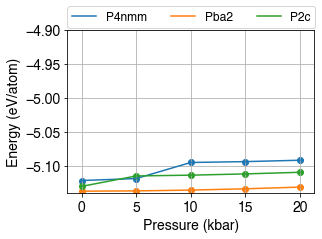

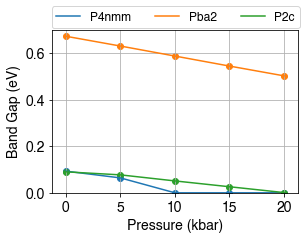

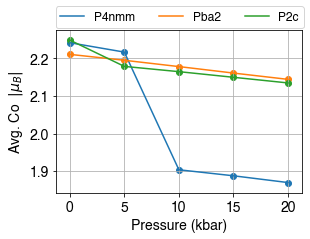

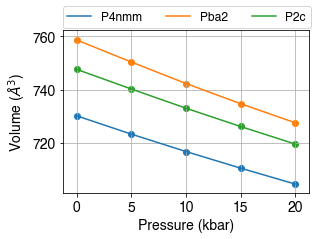

In [21]:
### AFM
afm_df = read_output('struc', loc0, loc1)
afm_df

for var in variables:
    plot_var('afm', afm_df, var, axis_label_dict[var], ylims=ylim_dict[var])

# plot_var('afm', afm_df, 'e_per_atom', , ylims=ylim_dict['e_per_atom'])  
# plot_var('afm', afm_df, 'band_gap', )  
# plot_var('afm', afm_df, 'mag_mom', )  
# plot_var('afm', afm_df, 'volume', )  

/home/kyledmiller/miniconda3/envs/informatics/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kyledmiller/miniconda3/envs/informatics/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


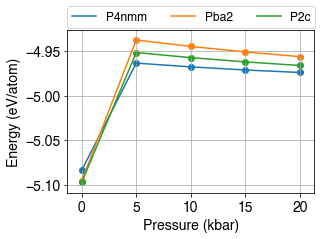

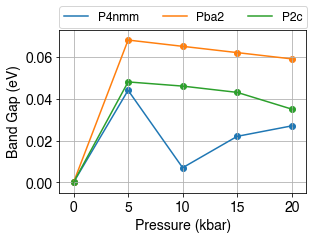

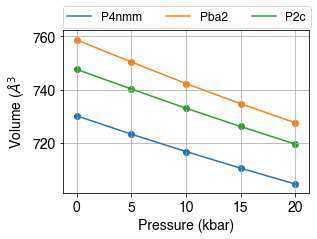

In [22]:
### NM
nm_df = read_output('nonmag', loc0, loc1)
nm_df

plot_var('nm', nm_df, 'e_per_atom', 'Energy (eV/atom)')  
plot_var('nm', nm_df, 'band_gap', 'Band Gap (eV)')  
# plot_var('nm', nm_df, 'mag_mom', 'Avg. Co  $|\mu_B|$')  
plot_var('nm', nm_df, 'volume', 'Volume ($\AA^3$')  